# План
1. Напоминание: переобучение, регуляризация и кросс-валидация
2. Pipeline решения ML задачи
3. Подбор гиперпараметров и ансамблирование моделей на примере размеченных данных

# Переобучение и методы борьбы с ним
Переобучение --- это одна из главных проблем, с которыми сталкиваются модели машинного обучения. Эффект переобучения состоит в том, что модель, подстраиваясь под обучающую выборку, "обращает внимание" на закономерности в выборке, которые не проявляются в общем случае и имеют характер совпадения. 

Переобучение проявляется тем больше, чем больше степеней свободы имеет модель. 
### Примеры:
* Решающее дерево со слишком большой глубиной может идеально подстроиться под обучающую выборку. Параметры решающего дерева --- это решающие правила во всех вершинах (всего $\sim 2^n$ решающих правил в дереве глубины $n$).

* Алгоритм $k$ ближайших соседей подстраивается под обучаюущую выборку и может рассматриваться как эталонный пример переобучения: любой локальный шум в данных приведёт к ошибке. Параметрами Knn являются **все элементы обучающей выборки**.

* Линейный алгоритм, построенный для выборки слишком маленького размера со слишком большим количеством признаков неизбежно переобучится под обучающую выборку.

Во всех примерах мы видим, что при слишком большой сложности модели по сравнению с количеством элементов в обучающей выборке переобучение имеет место. Строго говоря, **переобучение есть всегда, когда имеет место принятие решения в условии неполных данных**, то есть всегда в машинном обучении.

<img src='https://drive.google.com/uc?id=1wQQ0tMAtZVhbeQgUVdiS7kfmMw7P7NM9'/>

Чтобы нивелировать эффект переобучения, нужно поймать момент, в который качество на тестовой выборке начинает увеличиваться с ростом сложности модели. В этот момент обучение стоит останавливать.

## Переобучение многочленов
Смоделируем переобучение сколонность к переобучению полиномиальной зависимости с ростом степени многочлена. Сгенерируем искусственные данные из линейной зависимости с шумом и восстановим зависимость с помощью многочленов степени 1, 3, 4, 7.

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

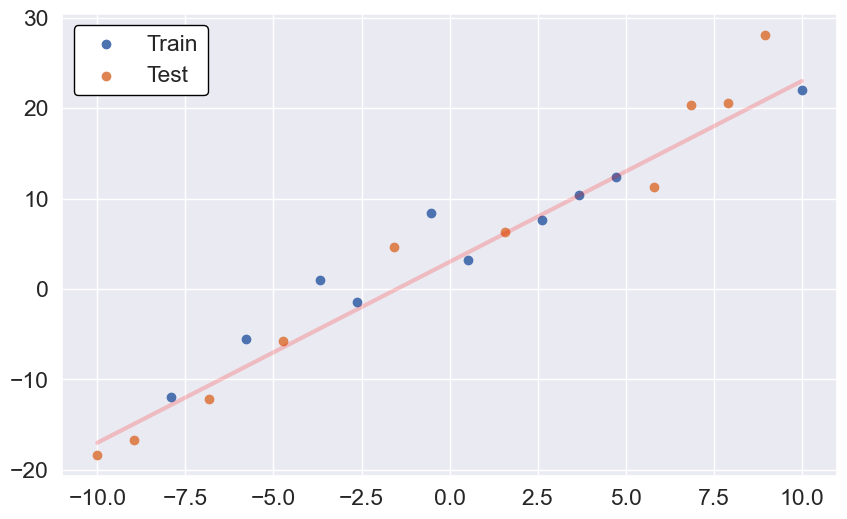

In [3]:
X = np.linspace(-10, 10, 20)

y = 2 * X + 3 + np.random.randn(20) * 3

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train, label='Train')
plt.scatter(X_test,y_test, label='Test')
plt.plot(X, 2 * X + 3, color='red', lw=3, alpha = 0.2)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.show()

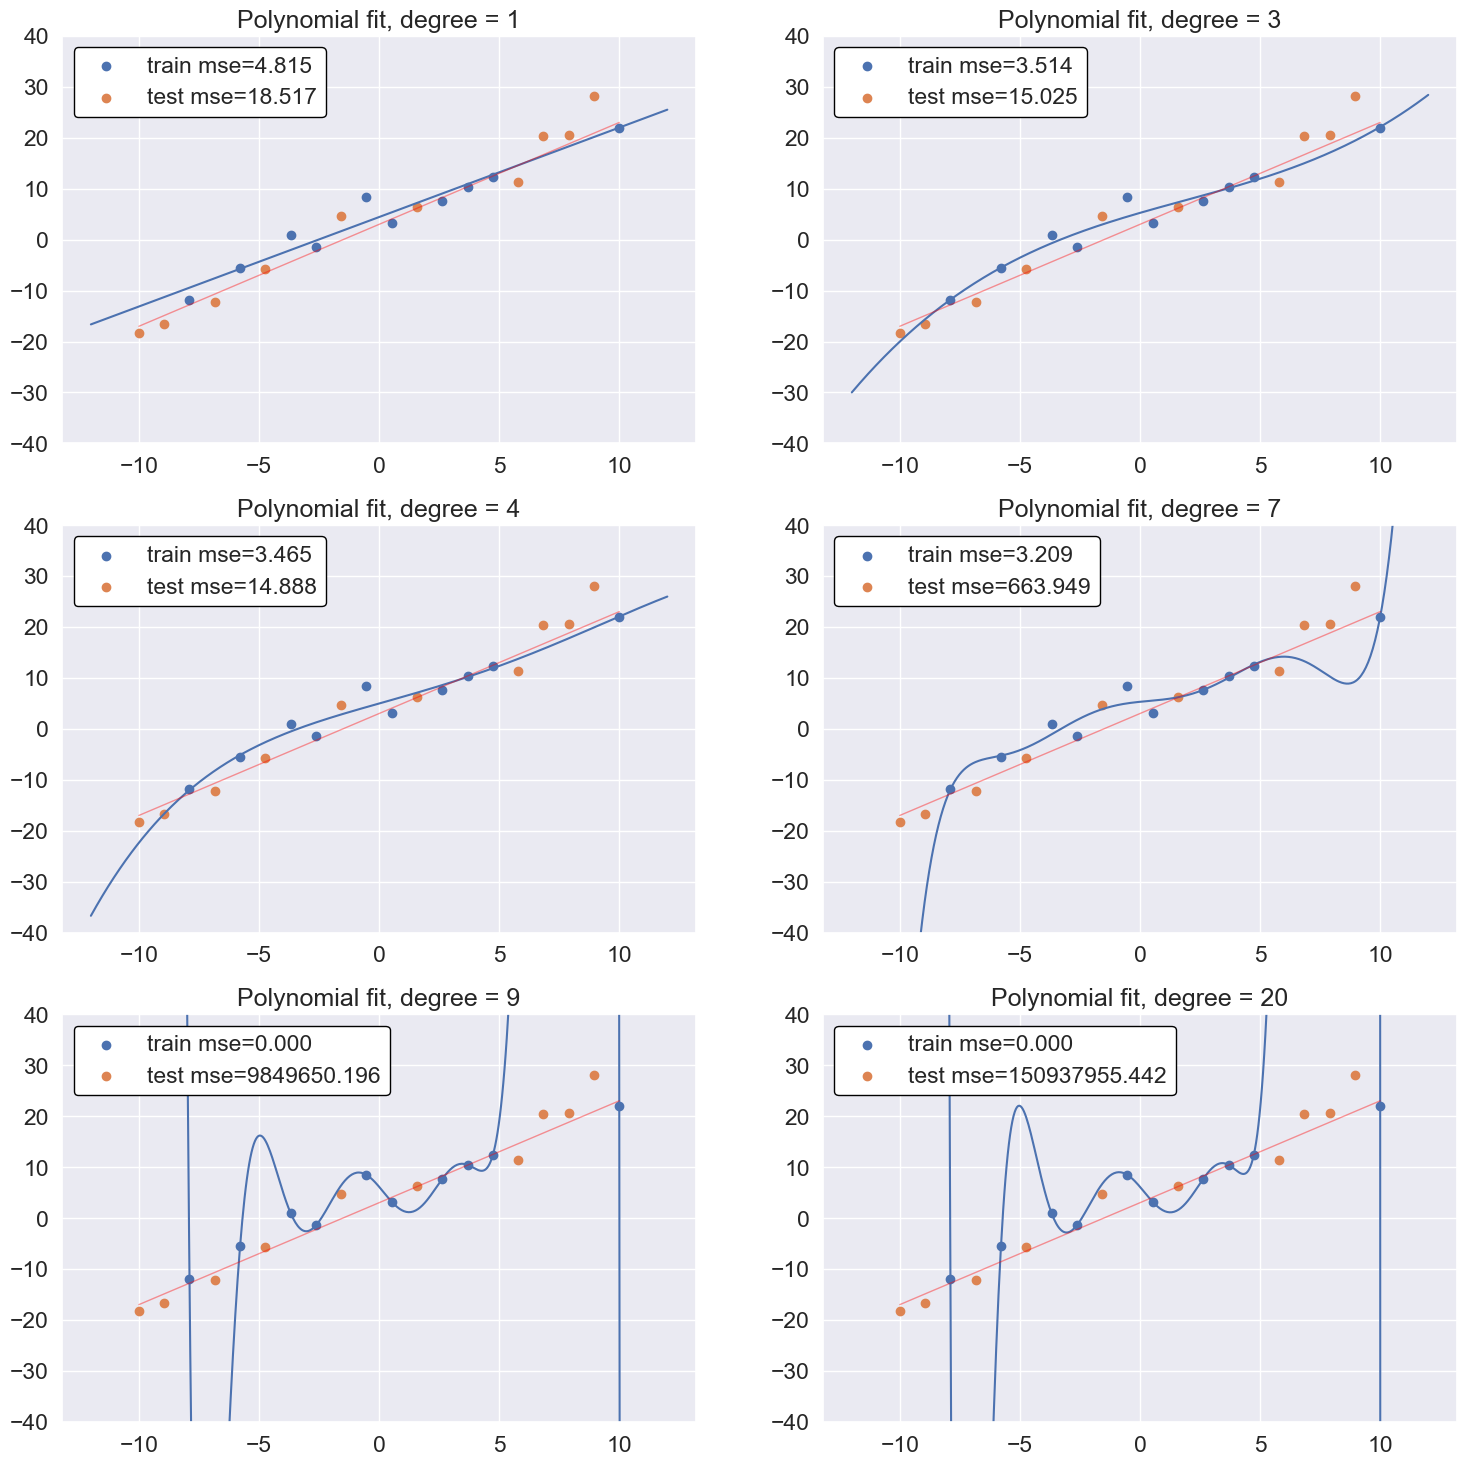

In [4]:
grid = np.linspace(-12, 12, 500)

fig, ax = plt.subplots(3, 2, figsize=(18,18))

ax = ax.ravel()

for i, deg in enumerate([1,3,4,7,9, 20]):
    
    poly = np.polyfit(X_train, y_train, deg)
    ax[i].set_title('Polynomial fit, degree = ' + str(deg))
    ax[i].scatter(X_train,y_train, 
                  label='train mse={:.3f}'.format(mean_squared_error(y_train, np.polyval(poly, X_train))))
    ax[i].scatter(X_test,y_test, 
                  label='test mse={:.3f}'.format(mean_squared_error(y_test, np.polyval(poly, X_test))))
    ax[i].set_ylim(-40, 40)
    ax[i].plot(grid, np.polyval(poly, grid))
    
    ax[i].plot(X, 2 * X + 3, color='red', lw=1, alpha = 0.4)
    legend_box = ax[i].legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
fig.show()

$$||x-y||, \text{x, y - векторы в 2-мерном пространстве}$$
$$||x - y|| = \sqrt{(x_1 - y_1)^2 + (x_2-y_2)^2}$$

$$||x-y||, \text{x, y - векторы в n-мерном пространстве}$$
$$||x - y|| = \sqrt{(x_1 - y_1)^2 + ... + (x_n-y_n)^2}$$

### Идея 1: регуляризация
Суть регуляризации состоит в том, чтобы добавлять к функции потерь слагаемое, ограничивающее рост весов модели. Например, обычная версия линейной регрессии выглядит так:
$$\frac{\sum\limits_{i=1}^{\ell}\left|\left|\langle x^i, w\rangle - y^i\right|\right|^2}{\ell} \rightarrow \min_{w}.$$

Регуляризованная версия:
$$\frac{\sum\limits_{i=1}^{\ell}\left|\left|\langle x^i, w\rangle - y^i\right|\right|^2}{\ell} + \frac{1}{C}\left|\left|w\right|\right|^2\rightarrow \min_{w}.$$

Такая версия линейной регресси называется Ridge-регрессией.  
Есть также Lasso-регрессия и ElasticNet.

Обычная версия логрегрессии:
$$-\frac{1}{\ell}\left( \sum\limits_{y^i = 1}\ln\sigma(\langle x, w\rangle) + \sum\limits_{y^i = -1}\ln(1-\sigma(\langle x, w\rangle))\right)\rightarrow \min_{w}$$

Регуляризованная версия:

$$-\frac{1}{\ell}\left( \sum\limits_{y^i = 1}\ln\sigma(\langle x, w\rangle) + \sum\limits_{y^i = -1}\ln(1-\sigma(\langle x, w\rangle))\right) + \frac{1}{C}||w||^2\rightarrow \min_{w}$$

### Идея 2: кросс-валидация

<img src='https://drive.google.com/uc?id=19TOWCsLwIjNSmcHzu46f6JqY5TEefm9h' width=600/>
Картинка говорит сама за себя. Чтобы получить более стабильное предсказание и точно увидеть переобучение, можно использовать кросс-валидацию. Это ещё пригодится дальше в ноутбуке.

# Pipeline решения ML-задачи

![lifecycle.png](https://drive.google.com/uc?export=view&id=1ZVVA3knTV7M0sTANYF4kOSMAZWG_BB5j)

![pipeline.jpg](https://drive.google.com/uc?export=view&id=1wt86eJI3wDb4SuRKFdtjvqKDaW0UDLvz)

# Выбор оптимальной модели

Теперь мы потренируемся обучению, оценке и валидации моделей, подбору оптимальных гиперпараметров, смешиванию моделей. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k.

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=', ')
# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() #этот метод разделит датасет по колонкам как в массиве columns

df = df.replace('?', np.nan)

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x=='>50K')) # Будем предсказывать 1(True), если зарплата больше 50K, 0(False) иначе

In [7]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
categorial_data.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States


In [8]:
df['education'].unique(), len(df['education'].unique())

(array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', '7th-8th', 'Doctorate', 'Assoc-voc', 'Prof-school',
        '5th-6th', '10th', 'Preschool', '12th', '1st-4th'], dtype=object),
 16)

### One-hot кодирование
Поскольку все алгоритмы машинного обучения, которые мы изучили, работают лишь с числовыми признаками, необходимо придумать способ обработки категориальных признаков, переводящий их в числовые. 
Одним из способов сделать это является One-hot кодирование. Его суть состоит в следующем. Пусть некоторая категориальная переменная (скажем, color) принимает $n$ различных значений (Red, Yellow, Green). Тогда можно создать $n$ новыx переменныx, соответствующих различным значениям категориального признака, каждая из которых равна 1 в том случае, если изначальный категориальный признак принимает такое значение, и 0 иначе. Принцип работы иллюстрирован на картинке.

<img src='https://drive.google.com/uc?id=17oipPzKv7JFU5Z94hBUzMb5zJJlpbwxj' width=700/>

В Pandas One-hot кодирование выполняется функцией pd.get_dummies. Сгенерируем One-hot признаки для нашего датасета. Сохраним полную матрицу объекты признаки в переменную X.

In [9]:
dummy_features = pd.get_dummies(categorial_data)

In [10]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X_origin = df.iloc[:, :-1]
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
y = df['salary']

In [12]:
X.shape, X_origin.shape

((30161, 104), (30161, 14))

Теперь всё готово для обучения алгоритмов.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.8,
                                                    random_state=42)

Напишем функцию, визуализирующую поиск оптимального гиперпараметра модели по сетке. Используем идею кросс-валидации.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [16]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, 
                            param_grid=parameters,
                            cv=5, 
                            scoring='f1',
                            n_jobs=-1, 
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error, 
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [18]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]
param_scales = ['log', 'ordinary']

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 2/5; 1/8] START n_neighbors=4...............................................
[CV 1/5; 1/8] START n_neighbors=4...............................................
[CV 3/5; 1/8] START n_neighbors=4...............................................
[CV 2/5; 2/8] START n_neighbors=7...............................................
[CV 4/5; 1/8] START n_neighbors=4...............................................
[CV 1/5; 2/8] START n_neighbors=7...............................................
[CV 5/5; 1/8] START n_neighbors=4...............................................
[CV 3/5; 2/8] START n_neighbors=7...............................................
[CV 2/5; 1/8] END ................n_neighbors=4;, score=0.362 total time=   4.1s
[CV 4/5; 2/8] START n_neighbors=7...............................................
[CV 1/5; 2/8] END ................n_neighbors=7;, score=0.378 total time=   4.4s
[CV 5/5; 2/8] START n_neighbors=7................

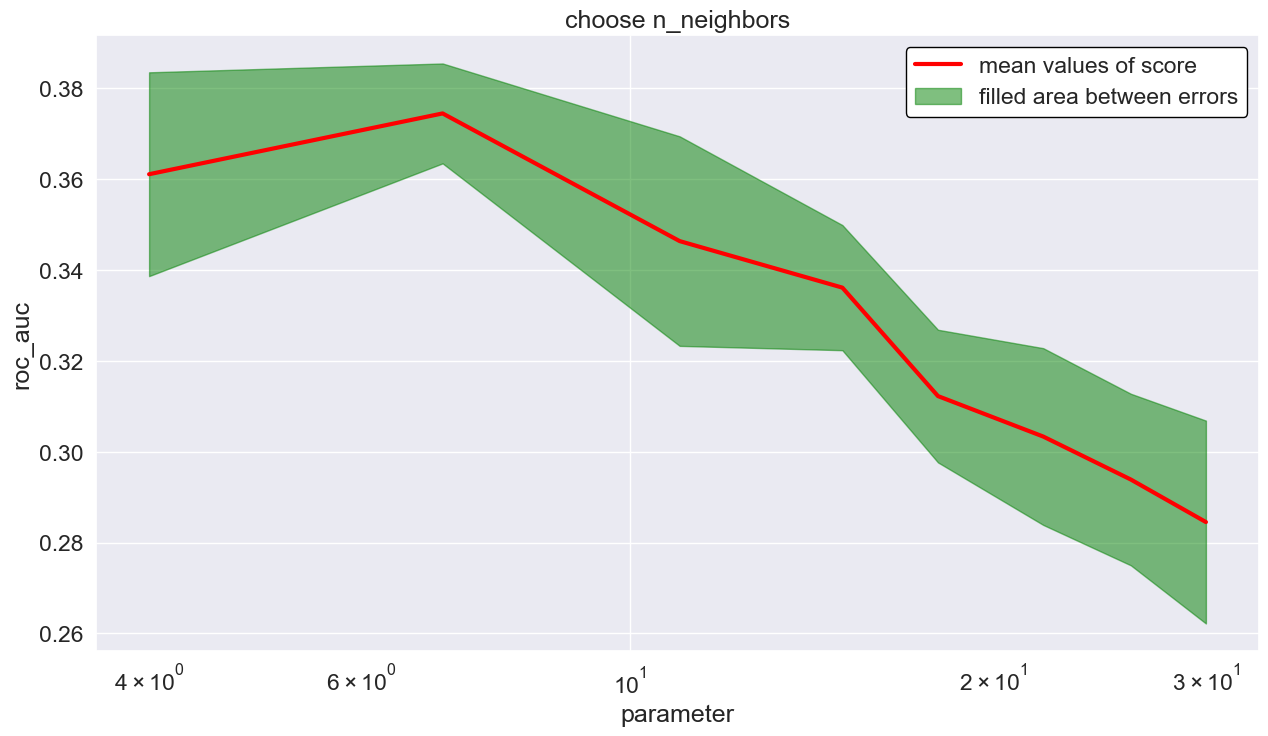

Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV 1/5; 1/29] START max_depth=1................................................
[CV 2/5; 1/29] START max_depth=1................................................
[CV 3/5; 1/29] START max_depth=1................................................
[CV 4/5; 1/29] START max_depth=1................................................
[CV 5/5; 1/29] START max_depth=1................................................
[CV 1/5; 2/29] START max_depth=2................................................
[CV 2/5; 2/29] START max_depth=2................................................
[CV 3/5; 2/29] START max_depth=2................................................
[CV 2/5; 1/29] END .................max_depth=1;, score=0.000 total time=   0.1s
[CV 5/5; 1/29] END .................max_depth=1;, score=0.000 total time=   0.1s
[CV 4/5; 2/29] START max_depth=2................................................
[CV 3/5; 1/29] END .................max_depth=1

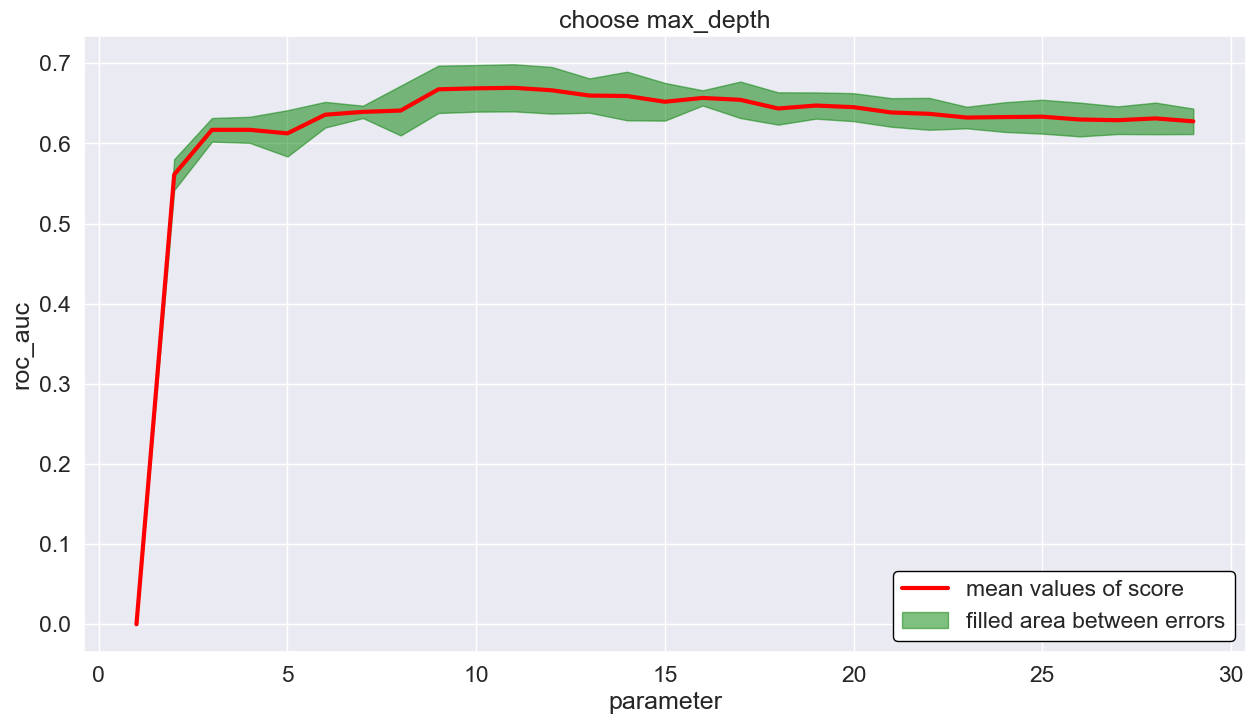

In [19]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

Подберём параметр n_estimators в алгоритме случайный лес. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменяется. 
Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большого количества деревьев, а затем рассмотреть подмножества нужного размера из исходного множества деревьев.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [22]:
max_trees = 100

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = []

for train_indices, val_indices in tqdm(kf.split(X_train), total=5):
    scores = []
    
    X_train_kf = X_train[train_indices]
    y_train_kf = y_train[train_indices]
    
    X_val_kf = X_train[val_indices]
    y_val_kf = y_train[val_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in tqdm(values, leave=False):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))
    
    scores = np.array(scores)
    
    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

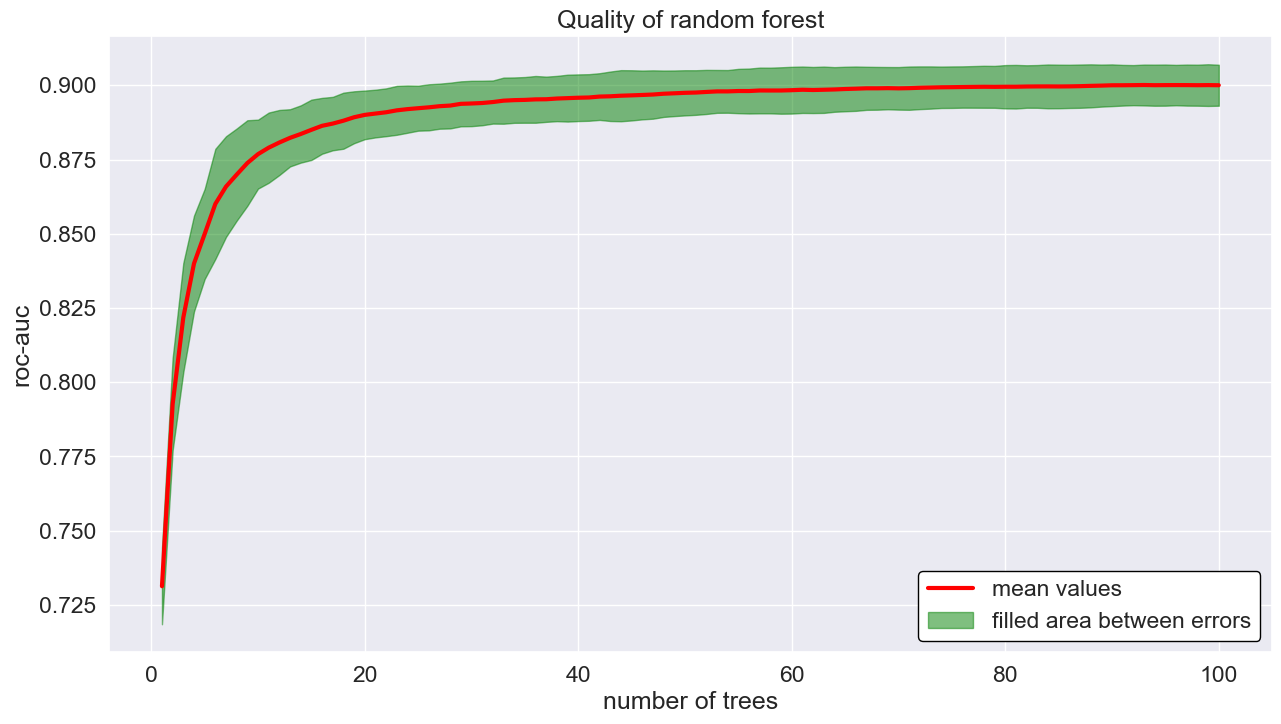

In [23]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values', color='red', lw=3)
plt.fill_between(values, 
                 mean_cross_val_score - 2 * std_cross_val_score, 
                 mean_cross_val_score + 2 * std_cross_val_score, 
                 color='green', 
                 label='filled area between errors',
                 alpha=0.5)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

### Нормировка признаков

Нормируем признаки и проделаем тот же эксперимент с алгоритмом ближайших соседей. Посмотрим, изменилось ли качество предсказания.

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

`StandardScaler` выполняет преобразование $$z = \frac{x - \mu}{\sigma}, \text{где $\sigma$ - стандартное отклонение, а  $\mu$ - среднее}$$

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START n_neighbors=4...............................................
[CV 2/5; 1/8] START n_neighbors=4...............................................
[CV 3/5; 1/8] START n_neighbors=4...............................................
[CV 4/5; 1/8] START n_neighbors=4...............................................
[CV 5/5; 1/8] START n_neighbors=4...............................................
[CV 1/5; 2/8] START n_neighbors=7...............................................
[CV 2/5; 2/8] START n_neighbors=7...............................................
[CV 3/5; 2/8] START n_neighbors=7...............................................
[CV 3/5; 1/8] END ................n_neighbors=4;, score=0.536 total time=   1.4s
[CV 1/5; 1/8] END ................n_neighbors=4;, score=0.554 total time=   1.4s
[CV 4/5; 2/8] START n_neighbors=7...............................................[CV 5/5; 2/8] START n_neighbors=7.................

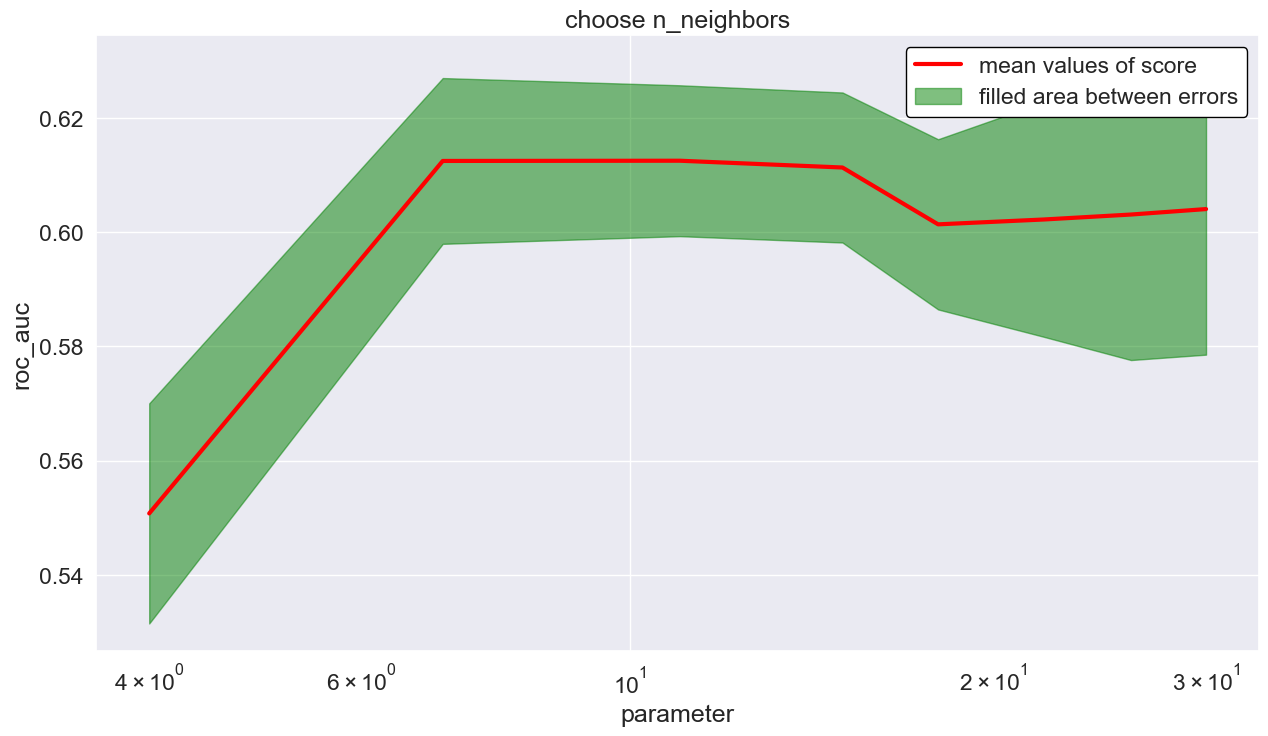

In [25]:
search_and_draw(X_train_scaled, y_train, KNeighborsClassifier(), 'n_neighbors', 
                np.array(np.linspace(4, 30, 8), dtype='int'), 'log');

Как и следовало ожидать, ни один из наших алгоритмов не побил случайный лес. Итак, видим, что на больших выборках бэггинг работает. Вычислим итоговое качество на test.

In [26]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

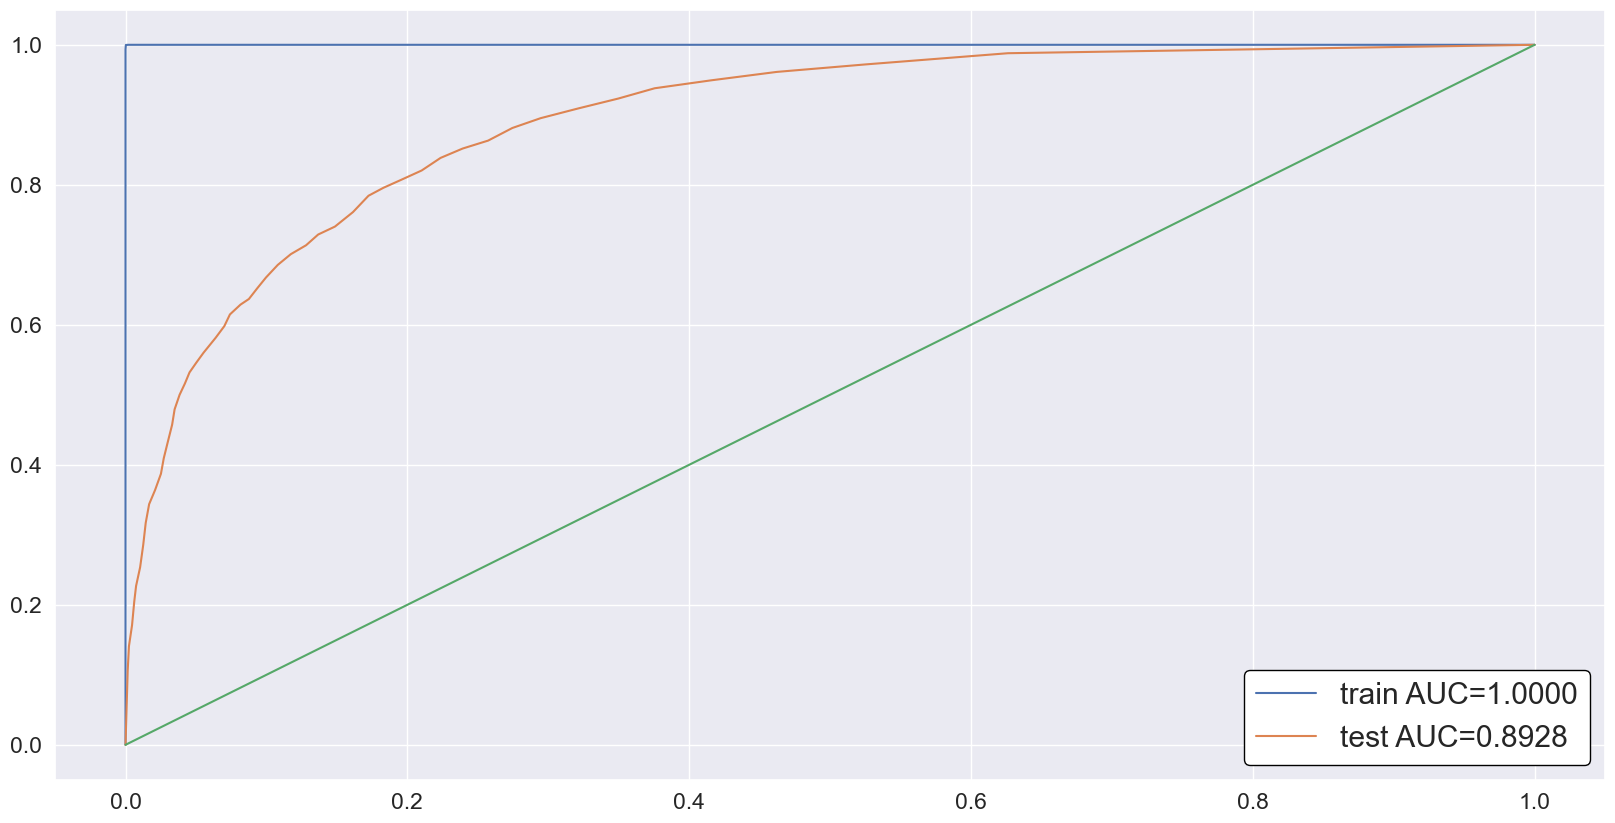

In [28]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## Что ещё можно делать:

Мы подбирали оптимальный одномерный параметр для алгоритма. Можно также:

* Искать по сетке не только численные гиперпараметры, но и категориальные, например, метрику в алгоритме ближайших соседей или критерий ветвления в решающем дереве.

* Искать оптимальный параметр по многомерной сетке. Перебрать все возможные варианты здесь не выйдет, потому что на это уйдёт слишком много времени. Зато можно перебирать случайные точки по сетке. Эта процедура называется Grid Random Search.

# Стекинг

Идея стекинга состоит в том, чтобы обучать разнообразные алгоритмы и использовать их в качестве новых признаков объектов. 

Чтобы избежать переобучения, необходимо разделить обучающую выборку на n фолдов. Для предсказания ответов на k-ом фолде алгоритм обучается на оставшихся n-1 фолдах и предсказывает ответ на k-ом фолде. Такую схему обучения-предсказания реализует функция sklearn.model_selection.cross_val_predict.

In [29]:
from sklearn.model_selection import cross_val_predict

Будем работать с тем же самым датасетом, что и ранее. Посмотрим, сумеем ли мы побить результаты случайного леса с помощью стекинга.

In [30]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [32]:
models = []
models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=30))
models.append(LogisticRegression())
models.append(RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1))
models.append(RandomForestClassifier(max_depth=7, n_estimators=50, n_jobs=-1))
models.append(DecisionTreeClassifier(max_depth=8))

In [33]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [34]:
for model in tqdm(models):
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_features_train, y_train)

y_train_predicted = stacking_model.predict_proba(meta_features_train)[:, 1]
y_test_predicted = stacking_model.predict_proba(meta_features_test)[:, 1]

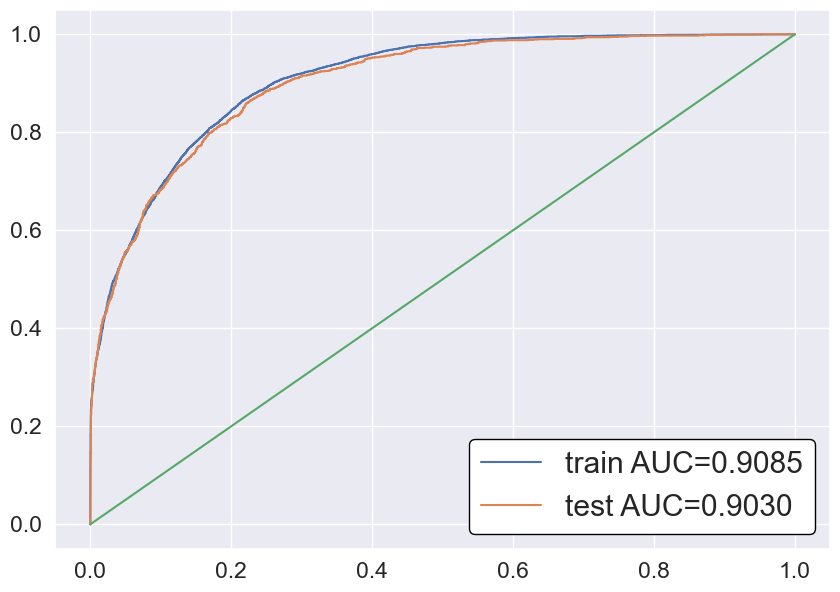

In [36]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

# Бустинг

Попробуем в пару-тройку строк побить всё то качество, которое мы так усердно искали.

In [37]:
# если этого модуля нет, то нужно раскомментировать следующую строчку и запустить
#!pip install xgboost

In [39]:
import xgboost

In [40]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

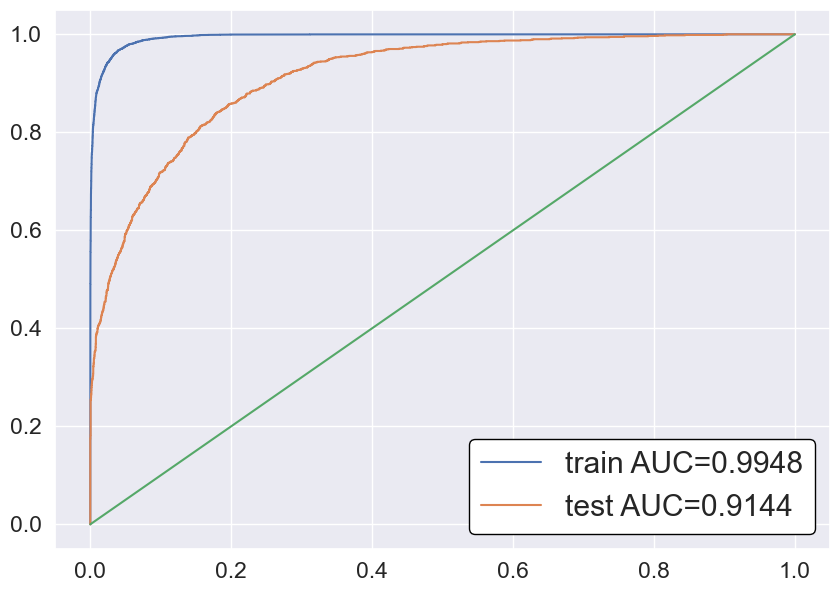

In [41]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Круто, да? А теперь попробуем "отечественного" производителя - CatBoost от Яндекса.

In [42]:
# если этого модуля нет, то нужно раскомментировать следующую строчку и запустить
#!pip install catboost

In [43]:
import catboost # документация: https://catboost.ai/docs

In [44]:
# CatBoost умеет работать с категориальными признаками сам
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values, 
                                                       train_size=0.8, 
                                                       random_state=42)

![docs_one_hot.png](https://drive.google.com/uc?export=view&id=119U7_cTX8imN13rr3Bi-vevHjo7kEXr6)

(из документации CatBoost)

In [45]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                             cat_features=categorical_indices)

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

Learning rate set to 0.175479
0:	learn: 0.5372165	total: 65.7ms	remaining: 13.1s
1:	learn: 0.4526979	total: 80.9ms	remaining: 8.01s
2:	learn: 0.4081255	total: 95.6ms	remaining: 6.28s
3:	learn: 0.3778820	total: 110ms	remaining: 5.4s
4:	learn: 0.3566011	total: 127ms	remaining: 4.95s
5:	learn: 0.3455788	total: 143ms	remaining: 4.63s
6:	learn: 0.3350149	total: 160ms	remaining: 4.41s
7:	learn: 0.3268511	total: 176ms	remaining: 4.23s
8:	learn: 0.3229313	total: 192ms	remaining: 4.08s
9:	learn: 0.3186000	total: 208ms	remaining: 3.96s
10:	learn: 0.3160912	total: 223ms	remaining: 3.83s
11:	learn: 0.3135176	total: 238ms	remaining: 3.73s
12:	learn: 0.3106304	total: 254ms	remaining: 3.65s
13:	learn: 0.3088799	total: 267ms	remaining: 3.54s
14:	learn: 0.3069790	total: 283ms	remaining: 3.49s
15:	learn: 0.3054777	total: 301ms	remaining: 3.46s
16:	learn: 0.3045585	total: 317ms	remaining: 3.41s
17:	learn: 0.3026705	total: 330ms	remaining: 3.34s
18:	learn: 0.3018712	total: 361ms	remaining: 3.44s
19:	learn

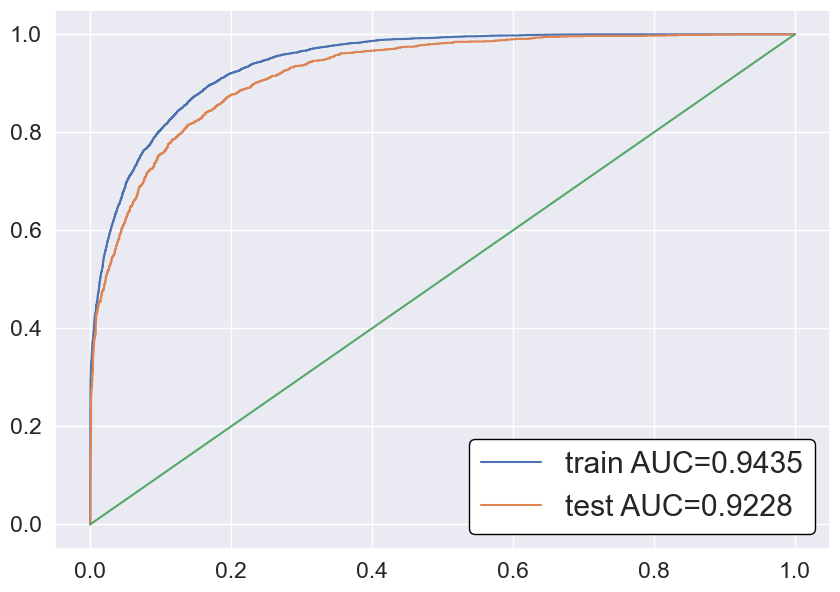

In [46]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [47]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, silent=True,
                                             cat_features=categorical_indices,
                                             eval_metric='AUC')
boosting_model.grid_search({'l2_leaf_reg': np.linspace(0, 1, 20)}, 
                           X_train_origin, 
                           y_train, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9190789019
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9190789	best: 0.9190789 (0)	total: 3.85s	remaining: 1m 13s

bestTest = 0.9201926181
bestIteration = 198

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9201926	best: 0.9201926 (1)	total: 8.22s	remaining: 1m 13s

bestTest = 0.9196754106
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.9196754	best: 0.9201926 (1)	total: 12.1s	remaining: 1m 8s

bestTest = 0.9197211255
bestIteration = 198

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.9197211	best: 0.9201926 (1)	total: 15.6s	remaining: 1m 2s

b

KeyboardInterrupt: 